In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from codac.datastore import client
import sys
import os
import glob
sys.path.append('/home/jleland/Coding/Projects/flopter')
from magopter import Magopter
import fitters as f
import classes.ivdata as iv
from scipy.interpolate import interp1d

In [2]:
folders = ['2018-05-01_Leland/', '2018-05-02_Leland/', '2018-05-03_Leland/',
               '2018-06-05_Leland/', '2018-06-06_Leland/', '2018-06-07_Leland/']
files = []
file_folders = []
for folder1 in folders:
    os.chdir(Magopter.get_data_path() + folder1)
    files.extend(glob.glob('*.adc'))
    file_folders.extend([folder1] * len(glob.glob('*.adc')))

files.sort()

file = files[-2]
ts_file = files[-1]
folder = file_folders[-2]
print([folder, file])
print([folder, ts_file])

mago = Magopter(folder, file)
mago.prepare()

['2018-06-07_Leland/', '2018-06-07 14h 38m 33s TT_06564321037878221702.adc']
['2018-06-07_Leland/', '2018-06-07_14h_33m_45s_TT_06564319866763108260.adc']
Ice.ConnectionRefusedException:
Connection refused
Database could not be connected to, operating in offline mode.


<IPython.core.display.Javascript object>


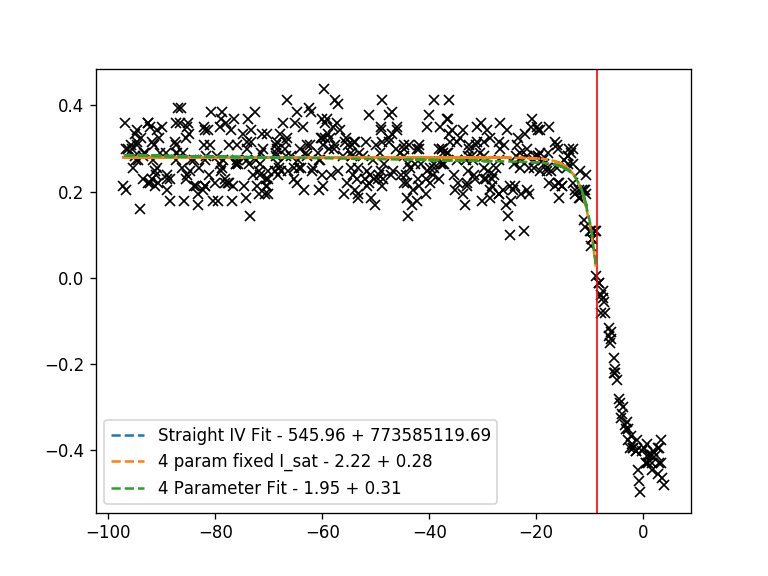

pos: 439 <class 'numpy.int64'>
-73.4705302858
[0.27843726307353017, 6.4429614899638171e-24, 2.2242971643947116]


In [17]:
# Creating a multi-fitting method for a set of IV data

iv_datas = mago.iv_arr_coax_0[20:23]

iv_data = iv_datas[0]

plt.figure()
plt.plot(*iv_data.split(), 'kx')
v_f = f.IVFitter.find_floating_pot(iv_data)

# iv_interp = interp1d(iv_data.current, iv_data.voltage)
# v_f_alt = iv_interp([0.0])
# print(v_f_alt)

# v_f_alt2 = iv_data['V'][np.abs(iv_data['I'] - 0).argmin()]
# print(v_f_alt2)

v_f_pos = np.abs(iv_data['V'] - v_f).argmin()
print('pos:', v_f_pos, type(v_f_pos))

plt.axvline(x=v_f, color='r', linestyle='-', linewidth='1')


str_sec = np.where(iv_data['V'] <= -30)
v_ss = iv_data['V'][str_sec]
i_ss = iv_data['I'][str_sec]

v_f_alt2 = v_ss[np.abs(i_ss - 0).argmin()]
print(v_f_alt2)

siv_f = f.StraightIVFitter(floating_potential=v_f)
siv_f_data = siv_f.fit(v_ss, i_ss)
I_sat_guess = siv_f_data.get_isat().value

fis_f = f.FullIVFixedISatFitter(I_sat_guess, floating_potential=v_f)
iv_data_trim = iv.trim_pos(iv_data, 0, v_f_pos)
first_fit_data = fis_f.fit_iv_data(iv_data_trim)

params = [I_sat_guess, *first_fit_data.fit_params.get_values()]
print(params)

fitter = f.FullIVFitter(floating_potential=v_f)
ff_data = fitter.fit_iv_data(iv_data_trim, initial_vals=params)

# plt.figure()
# plt.plot(*iv_data.split(), 'kx')
# for end in [0.8, 0.85, 0.9]:
#     iv_data_trim = iv.trim(iv_data, trim_end=end)
# #     plt.plot(*iv_data_trim.split())
#     plt.axvline(x=np.max(iv_data_trim['V']), linestyle='dotted', linewidth=0.5)
#     first_fit_data = fitter.fit_iv_data(iv_data_trim)
#     plt.plot(iv_data['V'], first_fit_data.fit_function(iv_data['V']), '--', label='{}: {:.2f}'.format(end, first_fit_data.get_temp(errors_fl=False)))


# plt.plot(iv_data['V'], first_fit_data.fit_function(iv_data['V']), '--', label=r'$V_f$: {:.2f}'.format(first_fit_data.get_temp(errors_fl=False)))
for fit_data in [siv_f_data, first_fit_data, ff_data]:
    plt.plot(*fit_data.get_fit_plottables(), '--', label=r'{} - {:3.2f} + {:3.2f}'.format(fit_data.fitter.name, *fit_data.get_temp().get_ve_pair()))

plt.legend()




# plt.figure()


# plt.axvline(x=v_f, color='k', linestyle='-', linewidth='1')